In [1]:
# from core import download_IC
# from core import download_ATNF

In [2]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
# from core import weights

read icdata
read uptdata
read eadata
read mspdata


In [3]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

In [4]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))

In [5]:
gamma_arr = [-1, -2.2, -2.5, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of threads:  14

Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...




In [6]:
@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel', cache=True)
def psr_wt_sing_e_gamma(psrno,enu, gamma, season=0):

    tt_upt = t_upt[season]
    dec = msdec[psrno]
    
    k=0
    l=0
    for i in prange(0, len(e_nu_wall)):
        if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
            k=i
            break

    for j in prange(0, len(dec_nu)):
        if dec_nu[j] <= dec and dec_nu[j+1] > dec:
            l=j
            break

        
    temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]

    return np.float64(tt_upt * temp_ea * (enu**gamma))


In [7]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]

In [8]:
wt_acc = []
for gamma in prange(4):
    wt_allpsr = []
    for season in tqdm(prange(10)):
        
        tmp = []
        for psrno in prange(p):
            # w_model = w_models[psrno]
            tmp.append(np.trapz(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

        wt_allpsr.append(np.array(tmp, dtype=np.float64))
        tmp = []
    wt_acc.append(wt_allpsr)
    wt_allpsr = []
    
wt_acc = np.asfarray(wt_acc, dtype=np.float64)
print("Calculated wt_acc for all pulsars and seasons and gamma")

100%|██████████| 10/10 [04:12<00:00, 25.28s/it]

Calculated wt_acc for all pulsars and seasons and gamma


In [9]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)

In [10]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2


In [11]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [12]:
print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

all_Si_ws_g_s = []
tmp = []
tmp_wt_acc = []
tmp_wt_acc_w_dist = []
tmp_wt_acc_w_s1400 = []

for gamma_index in tqdm(prange(4)):
    # for season in tqdm(prange(10)):
    tmp.append(Sik_sing_s_g(gamma_index, -1))
    tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
    tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
    tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
tmp = []
tmp_wt_acc = []
tmp_wt_acc_w_dist = []
tmp_wt_acc_w_s1400 = []
all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

print("Calculated S_i for all neutrinos and gammas and weighting schemes")


Calculating S_i for all neutrinos and gammas and weighting schemes...



100%|██████████| 4/4 [03:29<00:00, 52.37s/it]

Calculated S_i for all neutrinos and gammas and weighting schemes


In [13]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [14]:
print("\nCalculating Bi for all neutrinos\n")
all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
# all_Bi+=1e-90
print("\nCalculated Bi for all neutrinos")


Calculating Bi for all neutrinos


Calculated Bi for all neutrinos


In [15]:
#generates ns^ for a single pulsar a single season and a single energy

# @njit()
@vectorize(['float64(float64, float64, float64, float64, int64)'], target='parallel')
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0 = 1, season=0):
    '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


    tt_upt = t_upt[season]
    if enu <= 1e11 or enu >= 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu_wall)):
            if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
                k=i
                break

        for j in range(0, len(dec_nu)):
            if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                l=j
                break

            
        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV


In [16]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    ns_hat_wt_dist = 0
    ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):
        for psr in prange(p):
            # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
            wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])
            wt = wt_acc[gamma_arr.index(gamma)][season][psr]
            nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            
            ns_hat += np.trapz(nsop, x=e_nus)
    #         ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
    #         ns_hat_wt_dist += wt * np.trapz(nsop, x=e_nus) / (msdist[psr]**2)
    #         ns_hat_wt_s1400 += wt * np.trapz(nsop, x=e_nus) * mss1400[psr]
    # return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

            ns_hat_wt += (wt/wt_sum) * ns_hat
            ns_hat_wt_dist += (wt * w_models[1][psr]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1]))) * ns_hat
            ns_hat_wt_s1400 += (wt * w_models[2][psr]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2]))) * ns_hat
    return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

In [17]:
print("\nCalculating ns_HAT for all gamma and weighting schemes\n")

arr=[]
for gamma in prange(4):
    tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
    np.savetxt('ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
    arr.append(tmp)
    tmp = []

arr = np.array(arr, dtype=np.float64)
print("\nCalculationed ns_HAT for all gamma and weighting schemes")


Calculating ns_HAT for all gamma and weighting schemes



100%|██████████| 10/10 [04:22<00:00, 26.29s/it]


Calculationed ns_HAT for all gamma and weighting schemes


In [18]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

In [19]:
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(4):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(4):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return Ts_arr2(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        # pool = mul.Pool(8, maxtasksperchild=100)
        # op_arr = pool.map_async(TS_for_all_psrs2, arr[gamma][ws]*phio) #No units
        # temp = op_arr.get()
        # pool = []
        # op_arr = []
        # tmp = np.add(tmp, temp)
        # tmpp.append(tmp)
        # tmp = []
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


gamma = 1


100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


gamma = 2


100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


gamma = 3


100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


gamma = 1


100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s]


gamma = 2


100%|██████████| 1000/1000 [01:47<00:00,  9.33it/s]


gamma = 3


100%|██████████| 1000/1000 [01:46<00:00,  9.40it/s]


ws = 2
gamma = 0


100%|██████████| 1000/1000 [01:46<00:00,  9.42it/s]


gamma = 1


100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


gamma = 2


100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


gamma = 3


100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


ws = 3
gamma = 0


100%|██████████| 1000/1000 [01:46<00:00,  9.37it/s]


gamma = 1


100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]


gamma = 2


100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


gamma = 3


100%|██████████| 1000/1000 [01:46<00:00,  9.38it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


### $N \approx 10^6$

In [20]:
all_TSS = np.array(all_TSS, dtype=np.float64)

In [21]:
for w in range(3):
    for g in range(4):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
    print('wt\n')

-909475.5283430084 3008015.886807007
-3529399.78629489 3008023.465863087
-3227689.430542023 3008022.1658116495
-1450479.2591522709 3007946.9240464694
wt

-14217850.627488008 -2.685156064122774e-06
-8665938.472431477 14.844643219470402
-12350870.524535019 16.078430559462827
-7967116.852615138 15.982633407990756
wt

-7255453.9865090465 -3.0600271332259725e-05
-7808477.043300437 3.1781864850988994
-8764394.134270335 4.607909214263996
-7162748.2794962125 4.901450514665651
wt



In [22]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)
e2dfde = []

for gamma in prange(4):
    temp = []
    for phi in range(len(phio)):
        temp.append( 1e28 * dfde(1e14, gamma_arr[gamma], phio[phi]))        #in eV
    e2dfde.append(temp)

e2dfde = np.asarray(e2dfde)
mark = ['^', 'o', 's', 'd']


TS_vs_E2dfde_all_w_model_bins=1000000.png
DONE


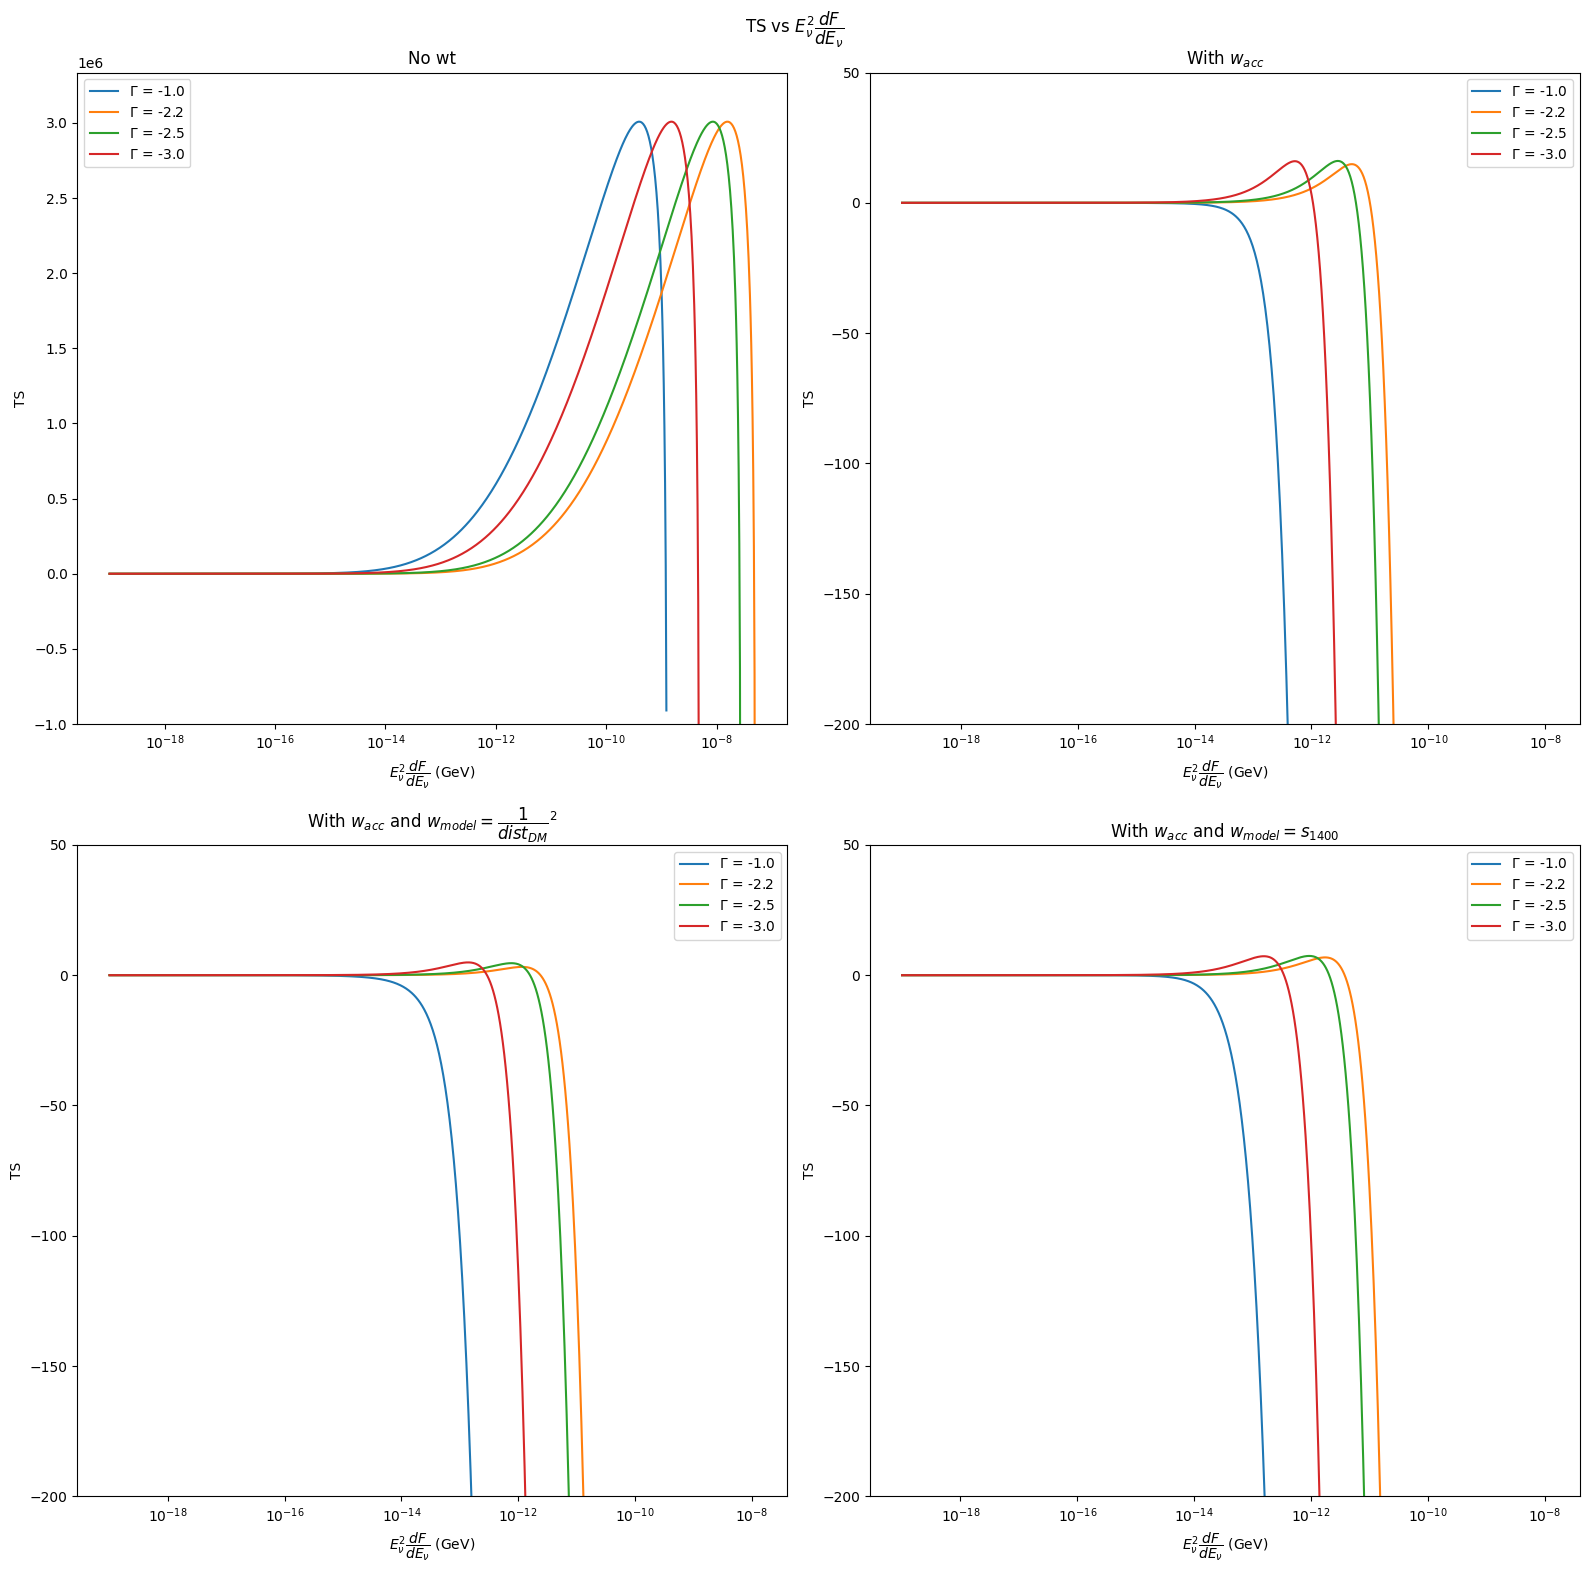

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

for gamma in [0, 1, 2, 3]:#range(4):
    axs[0,0].plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))    #in GeV

    axs[0,1].plot(e2dfde[gamma]/1e9, all_TSS[1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1,0].plot(e2dfde[gamma]/1e9, all_TSS[2][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[1,1].plot(e2dfde[gamma]/1e9, all_TSS[3][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

axs[0,0].legend()
axs[0,0].set_xscale('log')
axs[0,0].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[0,0].set_ylabel('TS')
# axs[0,0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0,0].set_ylim(-1e6)

axs[0,1].legend()
axs[0,1].set_xscale('log')
axs[0,1].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[0,1].set_ylabel('TS')
# axs[0,1].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0,1].set_ylim(-200, 50)

axs[1,0].legend()
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[1,0].set_ylabel('TS')
# axs[1,0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[1,0].set_ylim(-200, 50)

axs[1,1].legend()
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[1,1].set_ylabel('TS')
# axs[1,1].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[1,1].set_ylim(-200, 50)

axs[0,0].set_title('No wt')
axs[0,1].set_title('With $w_{acc}$')
axs[1,0].set_title('With $w_{acc}$ and $w_{model} = \dfrac{1}{dist_{DM}}^{2}$')
axs[1,1].set_title('With $w_{acc}$ and $w_{model} = s_{1400}$')

plt.suptitle('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
plt.tight_layout()
plt.savefig(f'TS_vs_E2dfde_all_w_model_bins={len(enus)}.png')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')